In [50]:
#imports
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import matplotlib
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.signal import blackman
from scipy.fft import fft, fftfreq
from miniesn_MBK import *

# %matplotlib widget: make plots interactive
matplotlib.use('nbagg') 
matplotlib.rcParams['figure.figsize']=(12,4)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# dpath = r'C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\AppliedML2021\BigProject\audio\homemade'
dpath = os.path.abspath(os.path.join(os.path.abspath(''), '..', 'HomemadeData'))
dfiles = os.listdir(dpath)

In [3]:
x, sr = librosa.load(os.path.join(dpath, dfiles[1]))
waveformTime = np.arange(start=0, stop=len(x)/sr, step=1/sr)

<IPython.core.display.Javascript object>


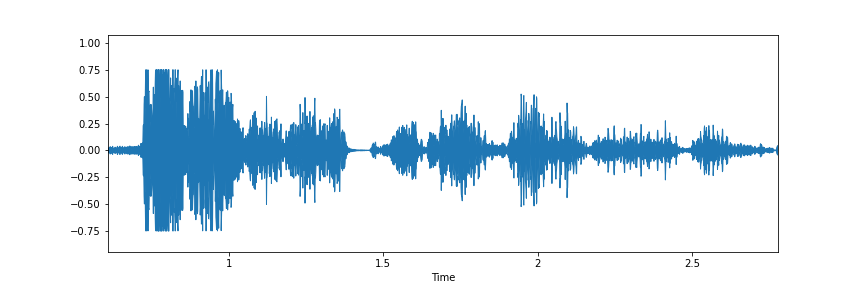

In [4]:
plt.figure('view waveform')
librosa.display.waveplot(x)
ipd.Audio(x, rate=sr)

In [5]:
hop_length = 500 # samples per frame
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length, n_fft=2048)
frames = range(len(onset_env))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

In [72]:
# hf=plt.figure('onset function')
# # hf.clf()
# ax=hf.add_subplot(111)
# ax.plot(t, onset_env, label='novelty function')
# # ax.plot(waveformTime*1e-9, x, label='audio waveform')
# ax.set_xlim(0, t.max())
# ax.set_ylim(0)
# ax.set_xlabel('Time (sec)')
# ax.set_title('Novelty Function')
# # ax.semilogy()
# hf.show()

In [73]:
# S = librosa.stft(onset_env, hop_length=1, n_fft=512)
# fourier_tempogram = np.absolute(S)

In [71]:
# hf2=plt.figure('tempogram')
# librosa.display.specshow(fourier_tempogram, sr=sr, hop_length=hop_length, x_axis='time')

In [70]:
# n0 = 100
# n1 = 300
# hf3=plt.figure('Novelty function zoom')
# plt.plot(t[n0:n1], onset_env[n0:n1])
# plt.xlim(t[n0], t[n1])
# plt.xlabel('Time (sec)')
# plt.title('Novelty Function')

# tmp = np.log1p(onset_env[n0:n1])
# r = librosa.autocorrelate(tmp)
# hf4=plt.figure('Autocorrelation of novelty function')
# plt.plot(60/t[:n1-n0], r)
# plt.xlim(20, 200)
# plt.xlabel('Tempo (BPM)')
# # plt.loglog()

# plt.ylim(0)

In [76]:
# try to predict waveform with ESN

from numpy.random import randint, uniform, normal
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
import scipy.linalg as la

dt = 1/sr

# Set up static random reservoir
Nhidden = 6000 # Number of hidden variables determine "memory" of reservoir

Nconnections    = 1000 # Number of connections in sparse hidden-to-hidden matrix Whh
spectral_radius = 1.5 # Spectral radius of Whh

Wih = uniform(-1,1,(Nhidden,1)) # Random input-to-hidden matrix
bh  = uniform(-1,1,(Nhidden,1)) # Random bias term
Whh = sparse_esn_reservoir(Nhidden,Nconnections,spectral_radius) # Hidden-to-hidden recurrence

offset = 18000
Ntrans   = 100+offset   # Number of transient initial steps before training
Ntrain   = 8000+offset # Number of steps to train on
Npredict = 2000+offset  # Number of steps for free-running prediction

data = np.array(x)

# First we split the data into training data (input/labels) and prediction labels
# (To verify that our prediction is correct)
inputs, labels, pred_labels = split_train_label_pred(data,Ntrain,Npredict)
# plt.figure('johnhilbert')

# plt.plot(inputs[:200])
# plt.plot(labels[:200])
# Second, we initialize the hidden state sequence from the input sequence
H = generate_state_matrix((Whh,Wih,bh),inputs,Ntrans)
# From this, we can do a simple least-squares fit to find the hidden-to-output
# matrix Woh. Other criteria can be built in to the fit, such as 
# Tikhonov-regularization to avoid over-fitting, or other constraints.
Who = lstsq_stable(H,labels[Ntrans:Ntrain])
# Our trained model now simply consists of the static matrices 
# Whh (hidden-hidden), Wih (input-hidden), and bh (bias hidden), which
# are problem-independent and are unrelated to the data, and the learned
# hidden-to-output matrix Who.
model = (Whh,Wih,bh,Who)
# First, we check: how well did our model predict the past? (How 
# well did we manage to fit the training data)

<IPython.core.display.Javascript object>


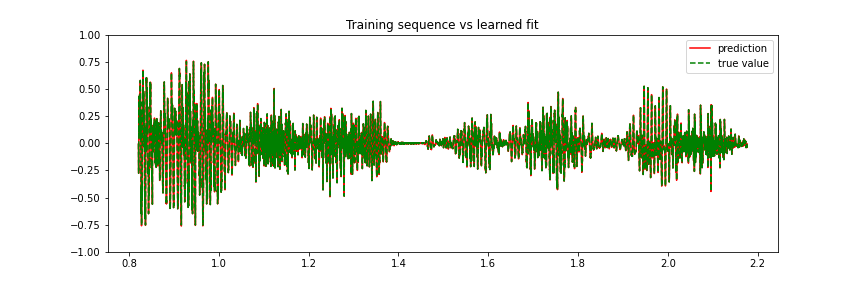

<IPython.core.display.Javascript object>


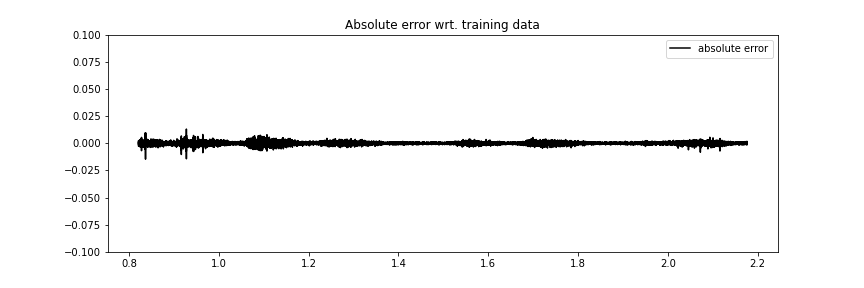

In [43]:
plt.figure()
plt.title("Training sequence vs learned fit")
plt.plot(waveformTime[Ntrans:Ntrain],Who.dot(H.T),color='r', label='prediction')
plt.plot(waveformTime[Ntrans:Ntrain],labels[Ntrans:Ntrain],linestyle='dashed',color='g', label='true value')
plt.legend()
plt.ylim([-1,1])
plt.show()

plt.figure()
plt.title("Absolute error wrt. training data")
plt.plot(waveformTime[Ntrans:Ntrain],Who.dot(H.T)-labels[Ntrans:Ntrain], color='k', label='absolute error')
plt.ylim([-0.1,0.1])
plt.legend()
plt.show()


ipd.Audio(Who.dot(H.T), rate=sr)
ipd.Audio(labels[Ntrans:Ntrain], rate=sr)

In [80]:
whotoplay=Who.dot(H.T)
# whotoplay=labels[Ntrans:Ntrain]
ipd.Audio(whotoplay, rate=sr)


In [77]:
# All right, looks pretty good! Maximum error of about 0.00001 in the training set.
# We finally validate by checking if we can predict 500 steps into the future:
state0 = H[-1]
input0 = labels[-1]

# Predict Npredict steps into the future, running free from final
# training input and hidden state.
ys, h = predict(model,state0,input0,Npredict)

<IPython.core.display.Javascript object>


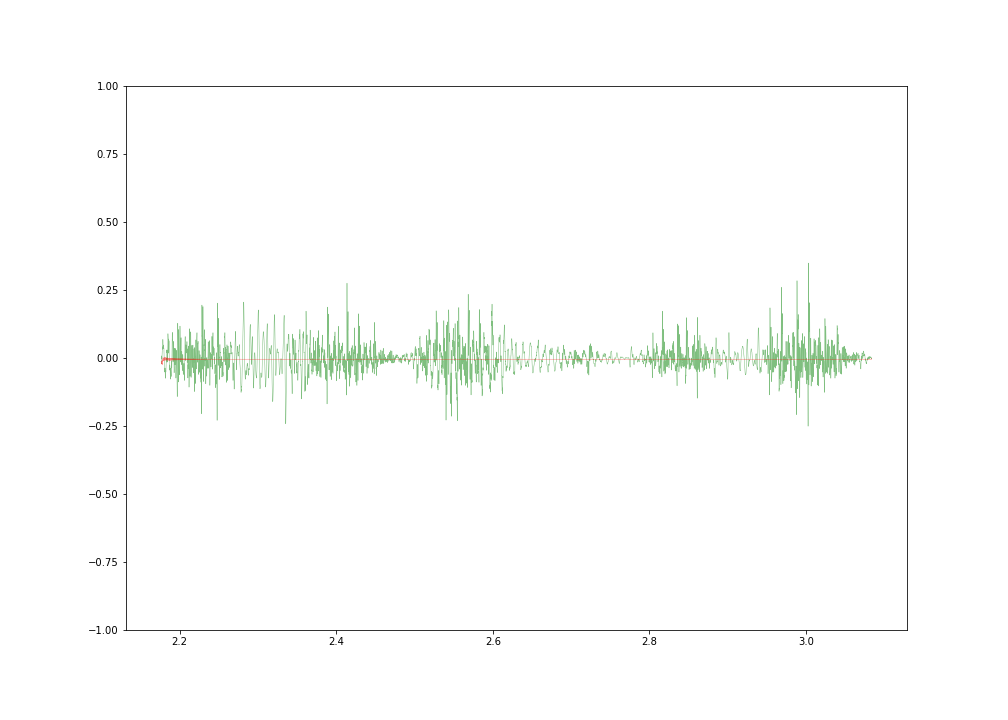

<IPython.core.display.Javascript object>


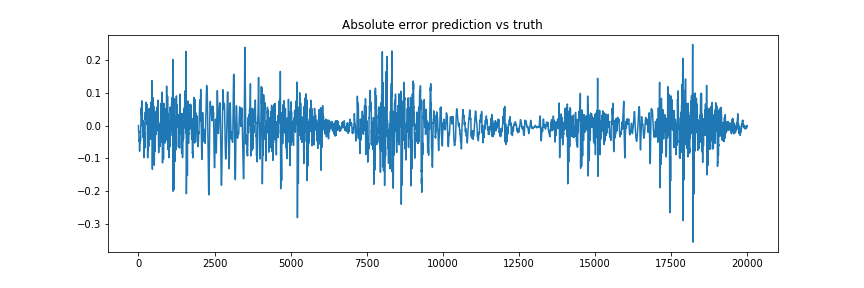

In [48]:
# Let's compare the 500-step forecast with the true continuation of the sequence
plt.figure(figsize=(14,10))
plt.plot(waveformTime[Ntrain:Ntrain+Npredict],pred_labels,color='g', alpha=0.5,linewidth=0.5)
plt.plot(waveformTime[Ntrain:Ntrain+Npredict],ys,color='r', alpha=0.5, linewidth=0.5)
plt.ylim([-1,1])
# plt.title("500-step prediction vs truth")
plt.show()
plt.figure()
plt.plot(ys-pred_labels)
plt.title("Absolute error prediction vs truth")
plt.show()

In [32]:
whotoplay=pred_labels
whotoplay=ys
ipd.Audio(whotoplay, rate=sr)

<IPython.core.display.Javascript object>


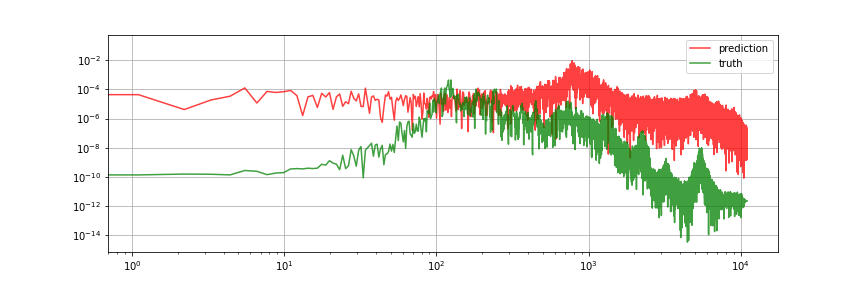

In [78]:
def getPSD(y, N, dt):
    w=blackman(N)
    PSD=(dt/N)*abs(np.fft.rfft(y))**2
    f=np.fft.rfftfreq(N,d=dt)
    return f, PSD
plt.figure('PSD of prediction and truth')
# N=len()
# T=N*dt
# w=blackman(N)
# predPSD = (dt/N)*abs(np.fft.rfft(ys*w))**2
# predFreq = np.fft.freq(N,d=dt)
predFreq, predPSD = getPSD(ys,len(ys),dt)
truthFreq, truthPSD = getPSD(pred_labels,len(ys),dt)
plt.plot(predFreq,predPSD,label='prediction',alpha=0.75,color='r')
plt.plot(truthFreq,truthPSD,label='truth',alpha=0.75,color='g')
plt.loglog()
plt.grid()
plt.legend()

In [ ]:
waveformTime

In [ ]:
len(waveformTime[Ntrain:Ntrain+Npredict])
len(ys)

In [12]:
Npredict
len(Who.dot(H.T))

9900

In [58]:
len(predFreq)

10001

In [59]:
len(predPSD)

10001

In [81]:
sr

22050